# Read in the data

In [57]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [58]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [59]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.4.3.final.0
python-bits: 64
OS: Linux
OS-release: 4.13.0-36-generic
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: en_US.UTF-8
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8

pandas: 0.19.2
nose: None
pip: 10.0.1
setuptools: 39.2.0
Cython: None
numpy: 1.12.1
scipy: 0.18.0
statsmodels: 0.8.0
xarray: None
IPython: 4.2.0
sphinx: None
patsy: 0.5.0
dateutil: 2.2
pytz: 2018.4
blosc: None
bottleneck: None
tables: None
numexpr: None
matplotlib: 1.5.1
openpyxl: 2.2.0-b1
xlrd: 1.1.0
xlwt: None
xlsxwriter: None
lxml: None
bs4: 4.4.1
html5lib: 1.0b8
httplib2: None
apiclient: None
sqlalchemy: 1.2.8
pymysql: None
psycopg2: 2.5.4 (dt dec pq3 ext)
jinja2: 2.8
boto: None
pandas_datareader: None


In [60]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [61]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [62]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [63]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [64]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [65]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

In [66]:
combined.corr().info()

<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, SAT Critical Reading Avg. Score to lon
Data columns (total 67 columns):
SAT Critical Reading Avg. Score         59 non-null float64
SAT Math Avg. Score                     59 non-null float64
SAT Writing Avg. Score                  59 non-null float64
sat_score                               59 non-null float64
AP Test Takers                          59 non-null float64
Total Exams Taken                       59 non-null float64
Number of Exams with scores 3 4 or 5    59 non-null float64
Total Cohort                            59 non-null float64
CSD                                     59 non-null float64
NUMBER OF STUDENTS / SEATS FILLED       59 non-null float64
NUMBER OF SECTIONS                      59 non-null float64
AVERAGE CLASS SIZE                      59 non-null float64
SIZE OF SMALLEST CLASS                  59 non-null float64
SIZE OF LARGEST CLASS                   59 non-null float64
SCHOOLWIDE PUPIL-TEACHER RATIO 

# Find correlations

In [67]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [68]:
type(correlations[survey_fields])

pandas.core.series.Series

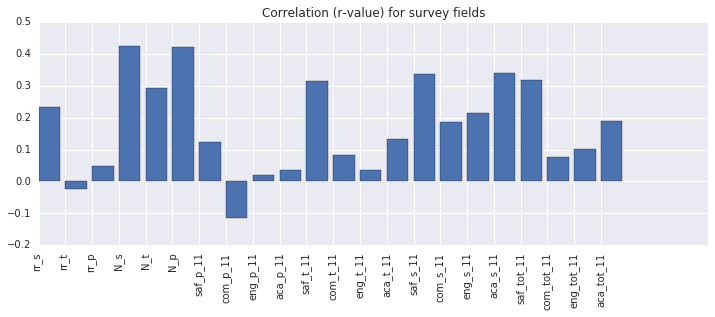

In [73]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
if "DBN" in survey_fields:
    survey_fields.remove("DBN")

import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(range(len(survey_fields)), correlations[survey_fields])
ax.set_xticks(range(len(survey_fields)))
ax.set_xticklabels(survey_fields, rotation=90)
ax.set_title("Correlation (r-value) for survey fields")

In [76]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)

## Investigate perceived safety's correlation to SAT scores.

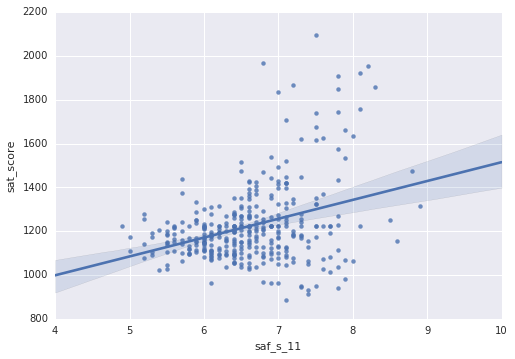

In [72]:
import seaborn as sns
# use the Seaborn function regplot to make a scatterplot
sns.regplot(x=combined["saf_s_11"], y=combined["sat_score"])

From the scatter plot above it appears that a perceived level of safety positively correlates positively with SAT scores, i.e. the safer a school is perceived to be the higher the SAT scores from students at that school will be. This is corroborated by the correlation score of 0.337639 for `saf_s_11` to `sat_score`.

In [78]:
import numpy as np
safety = combined.groupby("school_dist").agg(np.mean)
safety.head()

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
school_dist,,,,,,,,,,,,,,,,,,,,,
01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,115.244241,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,149.818949,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,156.005994,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,132.362265,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,120.623901,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


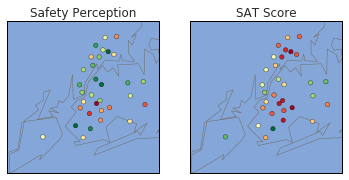

In [86]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.set_title("Safety Perception")
ax2 = fig.add_subplot(122)
ax2.set_title("SAT Score")

# create a Basemap instance
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i',
    ax=ax1
)

m2 = Basemap(
     projection='merc', 
     llcrnrlat=40.496044, 
     urcrnrlat=40.915256, 
     llcrnrlon=-74.255735, 
     urcrnrlon=-73.700272,
     resolution='i',
     ax=ax2
)

# draw the maps
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m2.drawmapboundary(fill_color='#85A6D9')
m2.drawcoastlines(color='#6D5F47', linewidth=.4)
m2.drawrivers(color='#6D5F47', linewidth=.4)

# get the district lat/lons
district_lons = safety["lon"].tolist()
district_lats = safety["lat"].tolist()

# plot each district's safety score on the map
m.scatter(x=district_lons, 
          y=district_lats,
          ax=ax1,
          s=20, 
          zorder=2, 
          latlon=True, 
          c=safety["saf_s_11"],
          cmap="RdYlGn")
m2.scatter(x=district_lons, 
          y=district_lats, 
          ax=ax2,
          s=20, 
          zorder=2, 
          latlon=True, 
          c=safety["sat_score"],
          cmap="RdYlGn")

Areas of the city that are perceived to be safer in general have higher SAT scores, but the correlation is not especially strong.

### Investigate racial differences for NYC SAT scores

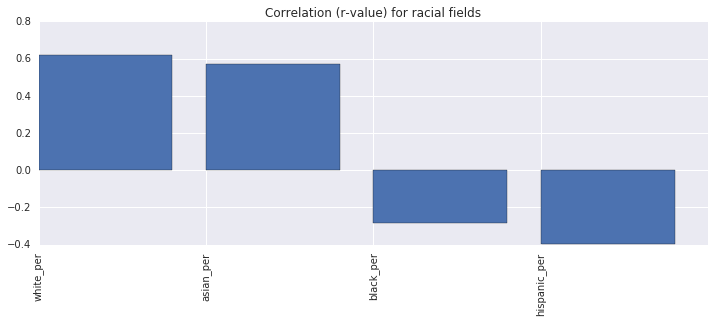

In [87]:
racial_fields = ['white_per',
                 'asian_per',
                 'black_per',
                 'hispanic_per']
                 
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(range(len(racial_fields)), correlations[racial_fields])
ax.set_xticks(range(len(racial_fields)))
ax.set_xticklabels(racial_fields, rotation=90)
ax.set_title("Correlation (r-value) for racial fields")

The above bar plot shows a positive correlation for White and Asian races and a negative correlation for Black and Hispanic races.

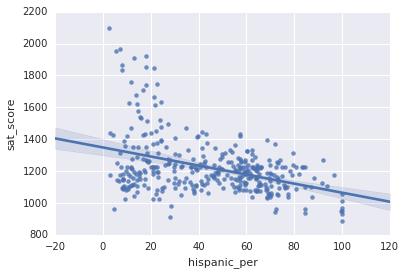

In [88]:
# use the Seaborn function regplot to make a scatterplot
sns.regplot(x=combined["hispanic_per"], y=combined["sat_score"])

The above shows a negative trend in terms of correlation between the percentage of Hispanics and SAT scores, i.e. the higher percentage of Hispanics in a school the lower will be the average SAT score.

In [101]:
print("NYC Schools with 95% or greater Hispanic populations:")
combined[combined["hispanic_per"] > 95]["SCHOOL NAME"].tolist()

NYC Schools with 95% or greater Hispanic populations:


['MANHATTAN BRIDGES HIGH SCHOOL',
 'WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL',
 'GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS',
 'ACADEMY FOR LANGUAGE AND TECHNOLOGY',
 'INTERNATIONAL SCHOOL FOR LIBERAL ARTS',
 'PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE',
 'MULTICULTURAL HIGH SCHOOL',
 'PAN AMERICAN INTERNATIONAL HIGH SCHOOL']

The above schools with overwhelmingly hispanic populations are international schools and/or located within sections of NYC with high percentage of Latinx immigrants.

In [103]:
print("NYC Schools with 10% or less Hispanic populations with an average SAT score above 1800:")
combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"].tolist()

NYC Schools with 10% or less Hispanic populations with an average SAT score above 1800:


['STUYVESANT HIGH SCHOOL',
 'BRONX HIGH SCHOOL OF SCIENCE',
 'BROOKLYN TECHNICAL HIGH SCHOOL',
 'QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE',
 'STATEN ISLAND TECHNICAL HIGH SCHOOL']

## Gender differences in SAT scores in NYC

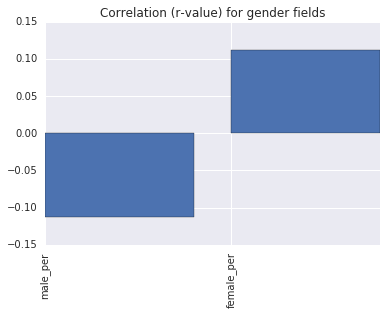

In [105]:
gender_percentage_cols = ['male_per', 'female_per']
fig, ax = plt.subplots()
ax.bar(range(len(gender_percentage_cols)), correlations[gender_percentage_cols])
ax.set_xticks(range(len(gender_percentage_cols)))
ax.set_xticklabels(gender_percentage_cols, rotation=90)
ax.set_title("Correlation (r-value) for gender fields")

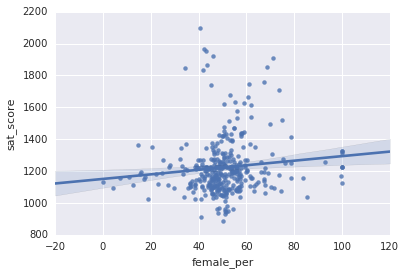

In [106]:
# use the Seaborn function regplot to make a scatterplot
sns.regplot(x=combined["female_per"], y=combined["sat_score"])

The above scatter plot shows a slight positive correlation between a school's percentage of female students and SAT scores. 

In [107]:
combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The above shows that high schools in NYC where the student body is predominantly female and where the average SAT score is above 1800 are schools where the curriculum is focused on arts and humanities.

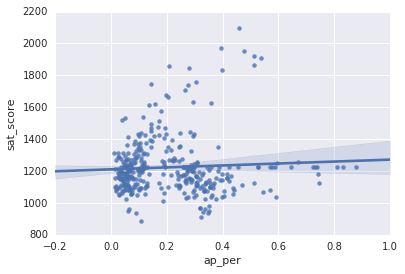

In [109]:
# compute the percentage of AP test takers, assign into a new column
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

# use the Seaborn function regplot to make a scatterplot
sns.regplot(x=combined["ap_per"], y=combined["sat_score"])

The above scatter plot shows only a slight positive correlation between AP test takers and SAT scores. somewhat counterintuitively.

Using the same sort of plotting we'll see if there's any correlation between class size adn SAT scores:

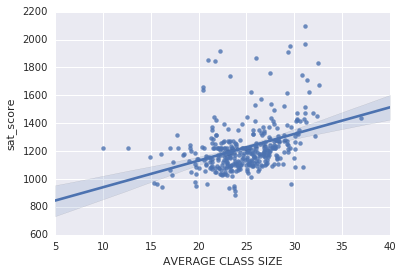

In [126]:
# print(data["class_size"].columns)

# perform a merge using an inner join on the DBN column
sizes_to_scores = data["class_size"][["DBN", "AVERAGE CLASS SIZE"]].merge(combined[["DBN", "sat_score"]], 
                                                                          how='inner', 

                                                                          on="DBN")
sizes_to_scores.reset_index("DBN")
sizes_to_scores.head()

# use the Seaborn function regplot to make a scatterplot
sns.regplot(x=sizes_to_scores["AVERAGE CLASS SIZE"], y=sizes_to_scores["sat_score"])